In [1]:
import os, re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Lab 06: Sequence Tagging

This is the analysis portion of the lab. The execution portion was done on Kaggle, and this notebook only analyzes the output log and the performance metrics. For all runs, 30 epochs of training was done out of requirements for time.

## Performance on test set

In [ ]:
# Use regex to capture the performance metrics on a line for test set.
ts = re.compile(r'TEST : ([\w-]+).+(\d\.\d+).+?(\d\.\d+).+?(\d\.\d+).+(\d\.\d+)')
def getBestTestPerf(lines, set):
    found = lines.str.contains('TEST : '+set) # pick all lines contain test info
    m = ts.match(lines[found].tail(1).values[0]) # get stats from last test line
    return (m[1], float(m[2]), float(m[3]), float(m[4])) # convert to floats

__Report performance metrics for all types of entities__

Note that the baseline run uses the same output  file as the full partial file in the next section.

In [133]:
with open('./tagger_outputs/part09.log', 'r') as f: # read baseline run
    raw = pd.Series(f.read().split('\n')) # read file, each row = line

# loop over all entity types and print the performance metrics
for ent in ['total', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']:
    perf = getBestTestPerf(raw, ent)
    print('Entities=%s: F1=%.4f, Recall=%.4f, Precision=%.4f'%perf)

Entities=total: F1=0.9061, Recall=0.9065, Precision=0.9057
Entities=B-PER: F1=0.9566, Recall=0.9536, Precision=0.9596
Entities=I-PER: F1=0.9828, Recall=0.9905, Precision=0.9753
Entities=B-LOC: F1=0.9318, Recall=0.9460, Precision=0.9180
Entities=I-LOC: F1=0.8607, Recall=0.9377, Precision=0.7954
Entities=B-MISC: F1=0.8305, Recall=0.8305, Precision=0.8305
Entities=I-MISC: F1=0.6653, Recall=0.7454, Precision=0.6007


The algorithm performed well on identifying `PER`, both begin and inside. However, the `I-LOC` and `I-MISC` have low performances. The algorithm works rather well on identifying when an entity begins, but not necessarily when it ends if the entity spans multiple words. 

__Get series of diminishing losses across epochs__  

Use regular expression to parse through the log and extracting Loss numbers on test data set

In [4]:
lossRE = re.compile(r'\(loss: (\d+\.\d+).+') # RE to capture loss value as text
tmp = raw.str.extract(lossRE)[0] # extract loss values as string
loss = tmp.dropna().values.astype(np.float) # drop NA, convert string to flaot

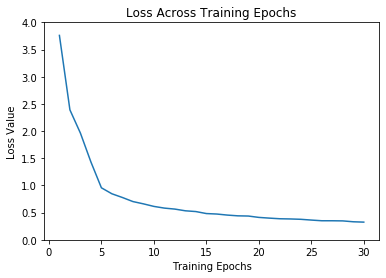

In [139]:
# plot loss across training epochs
plt.plot(range(1,31), loss)
plt.title('Loss Across Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Loss Value')
plt.ylim([0,4])
plt.show()

__Report range of performances__

There were three additional runs completed based on the entire training data set

In [135]:
raws = list() # loop thorugh all files and read output log
for f in ['baseline_0.log', 'baseline_1.log', 'baseline_2.log', 'part09.log']:
    with open('./tagger_outputs/'+f, 'r') as fh:
        raws.append( pd.Series(fh.read().split('\n')) ) # read files as lines

In [104]:
f1s = np.array([getBestTestPerf(r, 'total')[1] for r in raws])
print('Min F1 = %f'%f1s.min())
print('Mean F1 = %f'%f1s.mean())
print('Max F1 = %f'%f1s.max())

Min F1 = 0.902300
Mean F1 = 0.905275
Max F1 = 0.908800


Relatively, the performance is stable. The range of F1 over 4 runs are 0.006. The stochastic element of model fitting is minimal

### Performance as more data is used

On Kaggle, the input files were split into separate documents. Then the documents are split into 10 parts by having the same number of documents in each part. Then 10 partial files are comulatively constructed, where first partial file has 10% of the documents, second part has 20%, etc. Note that the test file is not split and the same test file is used for all 10 runs.

In [108]:
rawParts = list()
for f in ['part%02d.log'%n for n in range(10)]: # read in output of all 10 parts
    with open('./tagger_outputs/'+f, 'r') as fh:
        rawParts.append( pd.Series(fh.read().split('\n')) ) # read lines

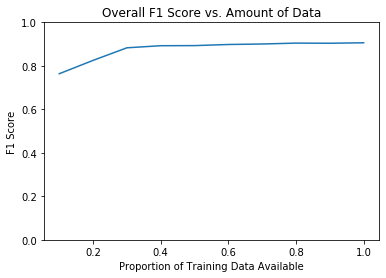

In [137]:
# Get overall F1 score on test set for 10 partial files
f1Parts = np.array([getBestTestPerf(r, 'total')[1] for r in rawParts])
plt.plot(0.1+np.arange(10)/10, f1Parts)
plt.title('Overall F1 Score vs. Amount of Data')
plt.xlabel('Proportion of Training Data Available')
plt.ylabel('F1 Score')
plt.ylim([0,1])
plt.show()

There is definitely diminishing marginal returns on performance as more data is used. The level of increase on the first 30% of training data was great, but leveled off after that. In fact, the performance on the addition of last 50% of data barely improved.

## Remapping All Entities

In this section, all entities (`LOC`, `MISC`, `PER`, `ORG`) were mapped into a generic `ENT` type. This was done again on Kaggle.

In [127]:
with open('./tagger_outputs/remapped.log', 'r') as f:
    reMap = pd.Series(f.read().split('\n')) # read file, each row = line

In [140]:
# print the output comparison on both types of runs
print('=== Entity Specific ===')
for ent in ['total', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']:
    perf = getBestTestPerf(raw, ent)
    print('Entities=%s: F1=%.4f, Recall=%.4f, Precision=%.4f'%perf)
print()
print('=== Entity Agnostic===')
for ent in ['total', 'B-ENT', 'I-ENT']:
    perf = getBestTestPerf(reMap, ent)
    print('Entities=%s: F1=%.4f, Recall=%.4f, Precision=%.4f'%perf)

=== Entity Specific ===
Entities=total: F1=0.9061, Recall=0.9065, Precision=0.9057
Entities=B-PER: F1=0.9566, Recall=0.9536, Precision=0.9596
Entities=I-PER: F1=0.9828, Recall=0.9905, Precision=0.9753
Entities=B-LOC: F1=0.9318, Recall=0.9460, Precision=0.9180
Entities=I-LOC: F1=0.8607, Recall=0.9377, Precision=0.7954
Entities=B-MISC: F1=0.8305, Recall=0.8305, Precision=0.8305
Entities=I-MISC: F1=0.6653, Recall=0.7454, Precision=0.6007

=== Entity Agnostic===
Entities=total: F1=0.9523, Recall=0.9552, Precision=0.9493
Entities=B-ENT: F1=0.9724, Recall=0.9754, Precision=0.9694
Entities=I-ENT: F1=0.9480, Recall=0.9720, Precision=0.9251


As expected, the overall performance improved. While all three overall metrics improved from around 0.90 to around 0.95, the real improvement are on the inside entities. For the entity-specific runs, the performance of `I-LOC` and `I-MISC` are low. The algorithm works well to identify `PER` entities correctly, but not the other two types.

In the entity-agnostic run, `I-ENT` have both high precision and recall. This means that the algorithm may be classifying them correctly as an entity, but not the specific right type of entity. This is why precision improved greatly.

## Performance of My Own Example

I constructed the test files using three sources. The first is an New York Times article from 1982 about white exiles from Rhodesia (Zimbabwe today) in South Africa. The second is from an article from NBC News about Chinese New Year celebration in San Francisco. The last is from the Wikipedia article on Mark Zuckerberg. I chose these three because I wanted to have a range of topics (technology, history, culture) as well as range of cultures to test the algorithm on. 

I expect commonly seen entities like South Africa, Johannesburg, Zimbabwe, San Francisco, Facebook, and Mark Zuckerberg to be easy to recognized. The location Rhodesia is also well established in history, so it should be recognized. Names like "Robin Ross" and "Chris Hughes" should also be recognized rather easily.

In terms of more difficult entities, I expect entities like "Unofficial Rhodesian Embassy" and "San Francisco's Chinatown" to be not recognized as easily. The former is due to it being unestablished, and the second is due to conflation of San Francisco within the entity. The name "Sing Ho Lei" should also be harder to recognize, as it is a foreign name and the word "sing" is also an English word with a different meaning. "Year of the Dog", which is a `MISC`, might also be harder to recognize as it is not as well established in English lexicon.

__Result of the Output__

`-DOCSTART- -DOCSTART- -DOCSTART-`

Technically , there are no ``<MISC>`` Rhodesians `</MISC>` left in the world , since there is no `<LOC>` Rhodesia `</LOC>` . But white immigrants who are streaming into `<LOC>` South Africa `</LOC>` from `<LOC>` Zimbabwe `</LOC>` cling to the name and to racial attitudes that sometimes seem to put them to the right of most local whites . 

" I 'm a `<MISC>` Rhodesian `</MISC>` ; I 'm definitely not a `<MISC>` Zimbabwean `</MISC>` , " insisted `<PER>` Robin Ross `</PER>` , a farm machinery salesman . 

But the `<LOC>` Rhodesia `</LOC>` that he and other recent immigrants still inhabit is a memory and a state of mind , not a place . 

A used - car salesman named `<PER>` Ed Johnstone `</PER>` , whose showroom in downtown `<LOC>` Johannesburg `</LOC>` is bedecked with `<MISC>` Rhodesian `</MISC>` regimental flags and a brass plate proclaiming it to be the " `<MISC>` Unofficial Rhodesian Embassy `</MISC>` , " summed up the attitude . 
<br><br>

`-DOCSTART- -DOCSTART- -DOCSTART-`

`<LOC>` San Francisco `</LOC>` ’s `<MISC>` Chinese New Year Parade `</MISC>` has attracted throngs of people for more than a century . 

This year , it will wind its way through the city ’s downtown on Feb. 24 to celebrate the `<MISC>` Year of the Dog `</MISC>` . 

Organizers expect approximately 1.2 million to attend in person , though the `<LOC>` San Francisco Police Department `</LOC>` does not conduct crowd estimates . 

`<PER>` Sing Ho Lei `</PER>` remembers recruiting friends from a community center in `<LOC>` San Francisco `</LOC>` ’s `<LOC>` Chinatown `</LOC>` as a teenager in 1965 to help carry the `<MISC>` Chinese New Year Parade `</MISC>` ’s long dragon — one of the highlights of the annual celebration . 
<br><br>

`-DOCSTART- -DOCSTART- -DOCSTART-`

`<PER>` Mark Elliot Zuckerberg `</PER>` is an `<MISC>` American `</MISC>` technology entrepreneur and philanthropist . 

`<PER>` Zuckerberg `</PER>` is known for co - founding and leading `<ORG>` Facebook `</ORG>` as its chairman and chief executive officer . 

`<LOC>` Born `</LOC>` in `<LOC>` White Plains `</LOC>` , `<LOC>` New York `</LOC>` , `<PER>` Zuckerberg `</PER>` attended `<ORG>` Harvard University `</ORG>` , where he launched `<ORG>` Facebook `</ORG>` from his dormitory room on February 4 , 2004 , with college roommates `<PER>` Eduardo Saverin `</PER>` , `<PER>` Andrew McCollum `</PER>` , `<PER>` Dustin Moskovitz `</PER>` , and `<PER>` Chris Hughes `</PER>` . 

Since 2010 , Time magazine has named `<PER>` Zuckerberg `</PER>` among the 100 wealthiest and most influential people in the world as a part of its Person of the Year award . 

In December 2016 , `<PER>` Zuckerberg `</PER>` was ranked 10th on `<PER>` Forbes `</PER>` list of `<MISC>` The World `</MISC>` 's `<ORG>` Most Powerful People `</ORG>` . 


The algorithm works relatively well. For example, it recognized unofficial entities like "Unofficial Rhodesian Embassy", non-famous names like "Ed Johnstone" and foreign names like "Sing Ho Lei". The majority of the entities were recognized (though may not necessarily be correctly). Events like "Chinese New Year Parade" and "Year fo the Dog" are also correctly recognized. The only notable omission was "Time" from Time magazine (which should be `ORG`). This was surprising because Times is a well established magazine. 

Other errors include tagging "Born" in "Born in White Plains, New York" as a location. 